In [39]:
import pandas as pd
import psycopg2 as pg2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, plot_roc_curve
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline as Pipeline_imb
import numpy as np




In [2]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [3]:
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='password')
df = pd.read_sql ("""Select * from auction_full WHERE bid > 0""", conn)
df_backup = df.copy()

In [25]:
df = df_backup.copy()

In [26]:
df.columns

Index(['auctionid', 'is_winner', 'cardtype', 'cashvalue', 'cardvalue',
       'bidvalue', 'limited_allowed', 'is_locked', 'auctiontime', 'bid',
       'is_bidomatic', 'bids_so_far', 'username', 'prevusers', 'username0',
       'distance0', 'is_bidomatic0', 'bids_so_far0', 'bom_bids_so_far0',
       'bom_streak0', 'perc_to_bin0', 'prev_win_bids0', 'username1',
       'distance1', 'is_bidomatic1', 'bids_so_far1', 'bom_bids_so_far1',
       'bom_streak1', 'perc_to_bin1', 'prev_win_bids1', 'username2',
       'distance2', 'is_bidomatic2', 'bids_so_far2', 'bom_bids_so_far2',
       'bom_streak2', 'perc_to_bin2', 'prev_win_bids2', 'username3',
       'distance3', 'is_bidomatic3', 'bids_so_far3', 'bom_bids_so_far3',
       'bom_streak3', 'perc_to_bin3', 'prev_win_bids3'],
      dtype='object')

In [27]:
df.is_bidomatic0 = df.is_bidomatic0.astype(str)
df.is_bidomatic1 = df.is_bidomatic1.astype(str)
df.is_bidomatic2 = df.is_bidomatic2.astype(str)
df.is_bidomatic3 = df.is_bidomatic3.astype(str)
#df["percent_near_bin0"] = df["bids_so_far0"]/(df["cashvalue"]*2.5)
#df["percent_near_bin1"] = df["bids_so_far1"]/(df["cashvalue"]*2.5)
#df["percent_near_bin2"] = df["bids_so_far2"]/(df["cashvalue"]*2.5)
#df["percent_near_bin3"] = df["bids_so_far3"]/(df["cashvalue"]*2.5)
#df[df["is_bidomatic0"]==False].streak0 = 0
#df[df["is_bidomatic1"]==False].streak1 = 0
#df[df["is_bidomatic2"]==False].streak2 = 0
#df[df["is_bidomatic3"]==False].streak3 = 0
df["fee"]=[0 if x == 0 else (1 if x < 50 else 1.99) for x in df["cardvalue"]]
df["time_of_day"]=[x.hour*60+x.minute for x in df["auctiontime"]]


In [28]:


y = df.pop('is_winner')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 


In [29]:
categorical_features = ['cardtype', 'limited_allowed', 'is_locked', 'is_bidomatic', 'is_bidomatic0', 'is_bidomatic1', 'is_bidomatic2', 'is_bidomatic3']
numeric_features = ['cashvalue','bidvalue', 'prevusers', 
                     'bids_so_far0', 'bom_streak0', 'perc_to_bin0',
                    'distance1', 'bids_so_far1', 'bom_streak1', 'perc_to_bin1',
                    'distance2', 'bids_so_far2', 'bom_streak2', 'perc_to_bin2',
                    'distance3', 'bids_so_far3', 'bom_streak3', 'perc_to_bin3', 'time_of_day']
numeric_transformer = Pipeline_imb(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
])
categorical_transformer = Pipeline_imb(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='error', drop='first'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
model = Pipeline_imb(steps=[('preprocessor', preprocessor),
                        ('sampler', RandomUnderSampler()),
                      ('classifier', RandomForestClassifier())])


In [30]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=-1,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                             

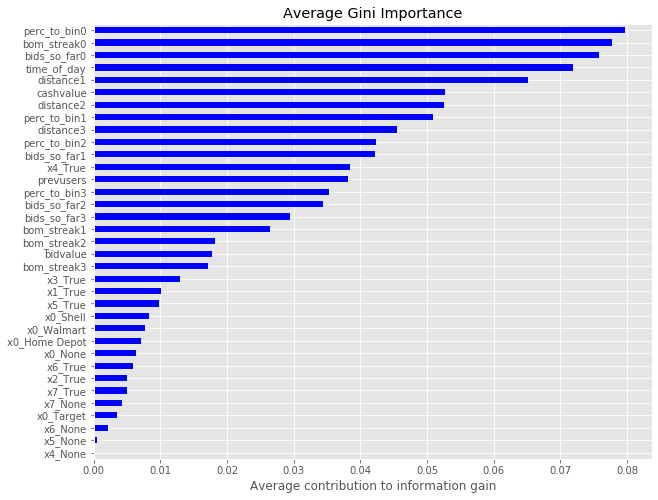

In [31]:
# Plot the feature importance
feat_scores = pd.Series(model.steps[2][1].feature_importances_,
                           index=get_column_names_from_ColumnTransformer(model.named_steps['preprocessor']))
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [55]:
probs = model.predict_proba(X_test)[:,1]
threshes = sorted(probs)

In [56]:
for thresh in np.arange(.5, 1,  .05):
    y_pred = probs > thresh
    cm = confusion_matrix(y_test, y_pred)
    print("*****************************")
    print("thresh:", thresh)
    print ("Accuracy {}: Precision: {}  Recall:{} ".format(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)))
    print(cm)
    true_positive_mask = (y_pred==True)&(y_test==True)
    profit = sum(X_test.cashvalue[true_positive_mask])-sum(y_pred)*.40 - sum(X_test.fee[true_positive_mask]) - sum(X_test.bid[true_positive_mask])/100
    profit_per_bid = profit/len(y_pred)
    print("profit:", profit)
    print("profit per bid:", profit_per_bid)
    print("*****************************")
    print("")

    


*****************************
thresh: 0.5
Accuracy 0.731767846788796: Precision: 0.009030352973492651  Recall:0.7140768588137009 
[[1023885  375193]
 [   1369    3419]]
profit: -22202.68999999993
profit per bid: -0.015815391212551575
*****************************

*****************************
thresh: 0.55
Accuracy 0.7823944735466205: Precision: 0.010136092765938036  Recall:0.649749373433584 
[[1095266  303812]
 [   1677    3111]]
profit: -8932.21999999995
profit per bid: -0.00636258731246426
*****************************

*****************************
thresh: 0.6000000000000001
Accuracy 0.8267398740335616: Precision: 0.011361121357432682  Recall:0.5789473684210527 
[[1157860  241218]
 [   2016    2772]]
profit: 1167.1300000000338
profit per bid: 0.000831368520927235
*****************************

*****************************
thresh: 0.6500000000000001
Accuracy 0.8665955297727845: Precision: 0.012840088839533593  Recall:0.502297410192147 
[[1214179  184899]
 [   2383    2405]]
profit:

In [34]:
plt.hist(X_test.bid[true_postive_mask], bins=max(X_test.bid[true_postive_mask]))

NameError: name 'true_postive_mask' is not defined

In [30]:
probs

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [17]:
df.groupby("cardvalue").mean()

,auctionid,cashvalue,bidvalue,limited_allowed,is_locked,bid,is_bidomatic,bids_so_far,prevusers,distance0,...,streak2,distance3,bids_so_far3,bom_bids_so_far3,streak3,percent_near_bin0,percent_near_bin1,percent_near_bin2,percent_near_bin3,fee
cardvalue,,,,,,,,,,,,,,,,,,,,,
0,5.505240e+08,66.250394,165.625986,0.111172,0.260553,347.421536,0.677917,68.125150,9.108642,1.0,...,17.088723,98.447473,31.909790,23.091964,17.553151,0.478326,0.253777,0.210986,0.202947,0.00
25,5.460416e+08,34.834283,24.585707,0.211536,0.222141,194.345423,0.736046,40.167455,7.275610,1.0,...,14.081483,71.114635,20.532727,14.919382,12.890052,0.462560,0.300437,0.256538,0.236425,1.00
50,5.462450e+08,60.245232,25.613079,0.248180,0.278878,385.644906,0.788903,67.437724,10.122257,1.0,...,21.157440,98.014894,33.628018,26.460799,20.065967,0.448382,0.283908,0.234492,0.223865,1.99
75,5.656352e+08,87.000000,30.000000,0.991317,0.345230,627.234897,0.794815,96.283477,13.862620,1.0,...,26.994163,113.775079,45.010425,35.408512,23.707165,0.442645,0.268318,0.226922,0.206944,1.99
100,5.354463e+08,112.000000,30.000000,0.989365,0.410961,933.733046,0.800432,118.997155,19.204526,1.0,...,30.230026,103.273053,57.310497,45.143771,29.221103,0.424977,0.258501,0.210006,0.204680,1.99
150,5.513270e+08,162.000000,30.000000,0.999841,0.388086,1276.004298,0.818262,157.790670,24.298331,1.0,...,31.317472,124.957844,64.439213,51.376596,30.729904,0.389586,0.230156,0.173891,0.159109,1.99


In [39]:
X_test[true_positive_mask]

,auctionid,cardtype,cashvalue,cardvalue,bidvalue,limited_allowed,is_locked,auctiontime,bid,is_bidomatic,...,distance3,is_bidomatic3,bids_so_far3,bom_bids_so_far3,streak3,percent_near_bin0,percent_near_bin1,percent_near_bin2,percent_near_bin3,fee
2910447,887389203,Home Depot,37,25,30,False,False,2019-11-16 16:38:20,11,True,...,NaN,None,NaN,NaN,NaN,0.032432,0.043243,NaN,NaN,1.00
4705875,527767839,Walmart,33,25,20,False,False,2019-10-12 22:05:13,5,True,...,NaN,None,NaN,NaN,NaN,0.024242,0.012121,0.012121,NaN,1.00
1947667,420138191,Walmart,33,25,20,False,False,2019-09-20 23:21:11,19,True,...,NaN,None,NaN,NaN,NaN,0.036364,0.072727,0.012121,NaN,1.00
476208,953532764,Shell,58,50,20,False,False,2019-09-30 23:31:44,12,True,...,NaN,None,NaN,NaN,NaN,0.041379,NaN,NaN,NaN,1.99
3309746,850485210,Amazon,37,25,30,False,False,2019-12-31 04:38:38,19,True,...,NaN,None,NaN,NaN,NaN,0.021622,0.086486,NaN,NaN,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3088849,873040706,Target,37,25,30,False,False,2020-02-03 00:42:04,4,True,...,NaN,None,NaN,NaN,NaN,0.010811,0.010811,NaN,NaN,1.00
2909337,854954503,Amazon,37,25,30,False,False,2020-01-01 10:07:40,17,True,...,NaN,None,NaN,NaN,NaN,0.054054,0.032432,NaN,NaN,1.00
5479896,884395453,None,6,0,15,True,False,2020-01-21 17:35:55,14,True,...,NaN,None,NaN,NaN,NaN,0.133333,0.200000,0.200000,NaN,0.00
2266706,350314897,Home Depot,33,25,20,False,False,2019-10-19 17:41:01,12,True,...,NaN,None,NaN,NaN,NaN,0.048485,0.012121,0.012121,NaN,1.00


In [40]:
sum(y_test)

4857

In [41]:
sum(y_pred)

2487

In [53]:
len(np.unique(probs))

3570

In [65]:
df.auctiontime[0].minute

41

In [57]:
y_pred = model.predict(X_test)
roc = roc_curve(y_test, y_pred)

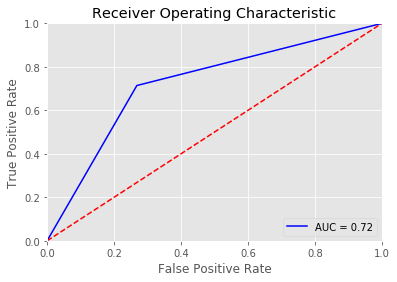

In [59]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [45]:
y_test.shape

(1403866,)

In [46]:
y_pred.shape

(1403866,)

In [47]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1023885  375193]
 [   1369    3419]]


In [49]:
model.predict_proba(X_test)


array([[0.99, 0.01],
       [0.81, 0.19],
       [0.53, 0.47],
       ...,
       [0.6 , 0.4 ],
       [0.55, 0.45],
       [0.94, 0.06]])

In [50]:
true_positive_mask = (y_pred==True)&(y_test==True)
profit = sum(X_test.cashvalue[true_positive_mask])-sum(y_pred)*.40 - sum(X_test.fee[true_positive_mask]) - sum(X_test.bid[true_positive_mask])/100


In [51]:
profit

-2228.29